In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [48]:
df = pd.read_csv("student-mat.csv")
print("Размер датасета:", df.shape)
display(df.head())

Размер датасета: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [49]:
target = "Fjob" # целевая переменная — работа отца
print("Уникальные значения Fjob:", df[target].unique())
print(df[target].value_counts())

Уникальные значения Fjob: ['teacher' 'other' 'services' 'health' 'at_home']
Fjob
other       217
services    111
teacher      29
at_home      20
health       18
Name: count, dtype: int64


In [50]:
print("\nИнфо по датасету:")
display(df.info())

print("\nПроверка пропусков:")
display(df.isna().sum())


Инфо по датасету:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    obj

None


Проверка пропусков:


,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


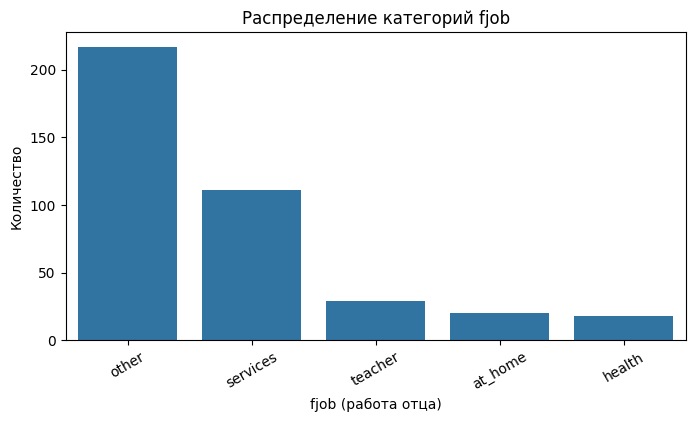

In [51]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x=target, order=df[target].value_counts().index)
plt.title("Распределение категорий fjob")
plt.xlabel("fjob (работа отца)")
plt.ylabel("Количество")
plt.xticks(rotation=30)
plt.show()

In [52]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nКатегориальные колонки:", cat_cols)

#chi2 между каждой категориальной переменной и fjob
chi_vs_target = {}
for col in cat_cols:
    if col == target:
        continue
    table = pd.crosstab(df[col], df[target])
    try:
        chi, p, dof, ex = chi2_contingency(table)
    except Exception as e:
        chi, p = np.nan, np.nan
    chi_vs_target[col] = {'chi2': float(chi), 'p_value': float(p)}

print("\nChi-square между категориальными признаками и fjob (p-value):")
chi_df = pd.DataFrame(chi_vs_target).T.sort_values('p_value')
display(chi_df)


Категориальные колонки: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

Chi-square между категориальными признаками и fjob (p-value):


,chi2,p_value
Mjob,73.380895,2.533577e-09
guardian,17.654570,2.397069e-02
school,8.411387,7.761918e-02
famsup,6.772568,1.484063e-01
reason,15.841848,1.985876e-01
schoolsup,5.984691,2.002945e-01
nursery,5.924464,2.048608e-01
sex,4.747741,3.141735e-01
Pstatus,4.682709,3.214291e-01
internet,4.284409,3.688815e-01


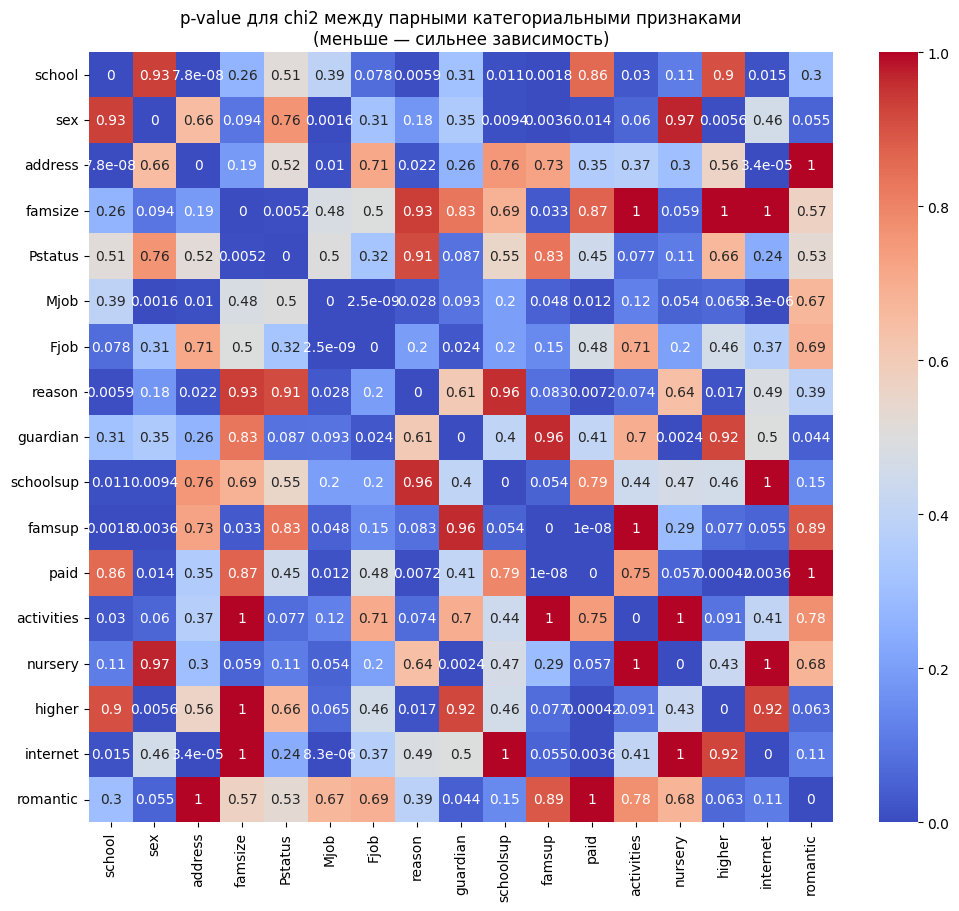

In [53]:
pairwise_p = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
for i in cat_cols:
    for j in cat_cols:
        if i == j:
            pairwise_p.loc[i,j] = 0.0
            continue
        table = pd.crosstab(df[i], df[j])
        try:
            chi, p, _, _ = chi2_contingency(table)
            pairwise_p.loc[i,j] = p
        except Exception:
            pairwise_p.loc[i,j] = np.nan

plt.figure(figsize=(12,10))
sns.heatmap(pairwise_p.astype(float), cmap="coolwarm", annot=True)
plt.title("p-value для chi2 между парными категориальными признаками\n(меньше — сильнее зависимость)")
plt.show()


In [54]:
#разделим признаки на числовые и категориальные
features = df.drop(columns=[target])
num_cols = features.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = features.select_dtypes(include=['object']).columns.tolist()

print("\nЧисловые признаки:", num_cols)
print("Категориальные признаки:", cat_cols)


#SelectKBest для числовых
if len(num_cols) > 0:
    selector_num = SelectKBest(score_func=chi2, k=min(5, len(num_cols)))
    X_num = features[num_cols].fillna(0).abs()
    y_codes = df[target].astype('category').cat.codes
    selector_num.fit(X_num, y_codes)
    best_num = [col for col, s in zip(num_cols, selector_num.get_support()) if s]
else:
    best_num = []

print("\nЛучшие числовые признаки (SelectKBest chi2):", best_num)


Числовые признаки: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Категориальные признаки: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

Лучшие числовые признаки (SelectKBest chi2): ['Medu', 'Fedu', 'Walc', 'G1', 'G3']


In [56]:
#оценка важности категориальных по chi2: one-hot кодируем и считаем chi2 для каждого dummy
ohe = OneHotEncoder(handle_unknown='ignore')
X_cat_ohe = ohe.fit_transform(features[cat_cols].fillna('NA'))
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

chi_scores_cat, p_vals_cat = chi2(X_cat_ohe, y_codes)
cat_scores_df = pd.DataFrame({
    'feature': ohe_feature_names,
    'chi2': chi_scores_cat,
    'p_value': p_vals_cat
}).sort_values('p_value')

top_n = 10
top_cat_dummies = cat_scores_df.head(top_n)
print("\nТоп категориальных dummy-признаков по chi2 (первые):")
display(top_cat_dummies)

important_cat_orig = sorted(set([name.split('_',1)[0] for name in top_cat_dummies['feature']]))
print("Категориальные колонки с сильной связью (по top-dummies):", important_cat_orig)

best_features = best_num + important_cat_orig
print("\nИтоговый список best_features :", best_features)


Топ категориальных dummy-признаков по chi2 (первые):


,feature,chi2,p_value
12,Mjob_other,20.771014,0.000352
14,Mjob_teacher,19.221931,0.000711
11,Mjob_health,15.574602,0.003646
19,guardian_father,11.508639,0.021405
13,Mjob_services,10.830852,0.028532
1,school_MS,7.431833,0.114753
17,reason_other,7.413096,0.115603
10,Mjob_at_home,6.982497,0.136816
23,schoolsup_yes,5.211984,0.266230
18,reason_reputation,4.927865,0.294779


Категориальные колонки с сильной связью (по top-dummies): ['Mjob', 'guardian', 'reason', 'school', 'schoolsup']

Итоговый список best_features : ['Medu', 'Fedu', 'Walc', 'G1', 'G3', 'Mjob', 'guardian', 'reason', 'school', 'schoolsup']


In [57]:
# нормализация и one-hot

X = df.drop(columns=[target])
y = df[target].astype('category')

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

if target in cat_cols:
    cat_cols.remove(target)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nРазмеры train/test:", X_train.shape, X_test.shape)


Размеры train/test: (316, 32) (79, 32)


In [58]:
#обучение модели (логистическая регрессия)
clf = Pipeline([
    ('preproc', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'))
])

clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'Medu', 'Fedu',
                                                   'traveltime', 'studytime',
                                                   'failures', 'famrel',
                                                   'freetime', 'goout', 'Dalc',
                                                   'Walc', 'health', 'absences',
                                                   'G1', 'G2', 'G3']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['school', 'sex', 'address',
                                                   'famsize', 'Pstatus', 'Mjob',
                                                   'reason', 'guardian',
                                                   'schoolsup', 'famsup',
                                                   'paid', 'activities',
                                                   'nursery', 'higher',
                                                   'internet', 'romantic'])])),
                ('logreg',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [59]:
y_pred = clf.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred, labels=y.cat.categories)
cm_df = pd.DataFrame(cm, index=y.cat.categories, columns=y.cat.categories)
display(cm_df)


Accuracy: 0.5189873417721519
Macro F1: 0.2898900476998949

Classification report:
              precision    recall  f1-score   support

     at_home       0.00      0.00      0.00         4
      health       0.25      0.25      0.25         4
       other       0.64      0.74      0.69        43
    services       0.44      0.32      0.37        22
     teacher       0.12      0.17      0.14         6

    accuracy                           0.52        79
   macro avg       0.29      0.30      0.29        79
weighted avg       0.49      0.52      0.50        79


Confusion matrix:


,at_home,health,other,services,teacher
at_home,0,0,4,0,0
health,0,1,0,2,1
other,1,2,32,6,2
services,0,1,10,7,4
teacher,0,0,4,1,1


In [60]:
preproc = clf.named_steps['preproc']
# get feature names:
num_features_after = num_cols
cat_encoder = preproc.named_transformers_['cat']
cat_features_after = list(cat_encoder.get_feature_names_out(cat_cols)) if hasattr(cat_encoder, 'get_feature_names_out') else []
all_feature_names = list(num_features_after) + cat_features_after

coefs = clf.named_steps['logreg'].coef_  # shape (n_classes, n_features)
abs_mean_coef = np.mean(np.abs(coefs), axis=0)
feat_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': abs_mean_coef
}).sort_values('importance', ascending=False).head(20)

print("\nТоп признаков по абсолютному среднему коэффициенту:")
display(feat_importance)


Топ признаков по абсолютному среднему коэффициенту:


,feature,importance
2,Fedu,0.887497
13,G1,0.631950
28,Mjob_other,0.529450
27,Mjob_health,0.511468
30,Mjob_teacher,0.501575
10,Walc,0.487457
1,Medu,0.479171
38,schoolsup_no,0.452463
39,schoolsup_yes,0.452288
9,Dalc,0.373301


Модель логистической регрессии показала слабое качество: точность около 0.52 и низкий macro-F1 = 0.29. Она уверенно распознаёт только самый частый класс (other), в то время как редкие категории почти всегда классифицируются неправильно. Матрица ошибок подтверждает, что модель путает малые классы между собой и чаще всего относит их к other. Основная причина - сильный дисбаланс данных и недостаточная информативность признаков для точного разделения категорий. На предсказания сильнее всего влияли образование родителей, оценки и профессия матери, но этого недостаточно для качественной многоклассовой классификации, поэтому модели требуется доработка.